# **Clasificación de imágenes (CIFAR-10 data-set)**
En este Jupyter Notebook mostraremos cómo clasificar un dat-set de 60,000 imágenes para su correcta clasificación. Nos encontramos ante un claro ejemplo de clasificación, para lo cual haremos uso de una red profunda convolucional que terminará en una capa de salida densa fully-connected del tamaño del número de etiquetas del que consta nuestro data-set.

##Importar Líbrerias

In [344]:
import os
#import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.models import load_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [347]:
import tensorflow as tf
import tensorflow_datasets as tfds


##Cargar conjunto de datos

- [tensorflow datasets](https://www.tensorflow.org/datasets/catalog/mnist?hl=es-419)

In [345]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [346]:
# Si train_labels es unidimensional, aplícalo de esta manera
if len(train_labels.shape) == 1:
    train_labels = to_categorical(train_labels)


In [348]:
# Load the MNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [349]:
from tensorflow.keras.utils import to_categorical

# Convierte etiquetas a one-hot encoding si estás en una clasificación multiclase
train_labels = to_categorical(train_labels[:60000, 0])


In [350]:
train_features = train_features.reshape(60000, -1)  # Pasa de (60000, 28, 28) a (60000, 784)


In [351]:
num_test, img_rows, img_cols = test_images.shape


In [352]:
test_images = test_images.reshape(num_test, 1, img_rows, img_cols)  # Añade un canal para escala de grises


##Mostrar imagenes del conjunto de datos



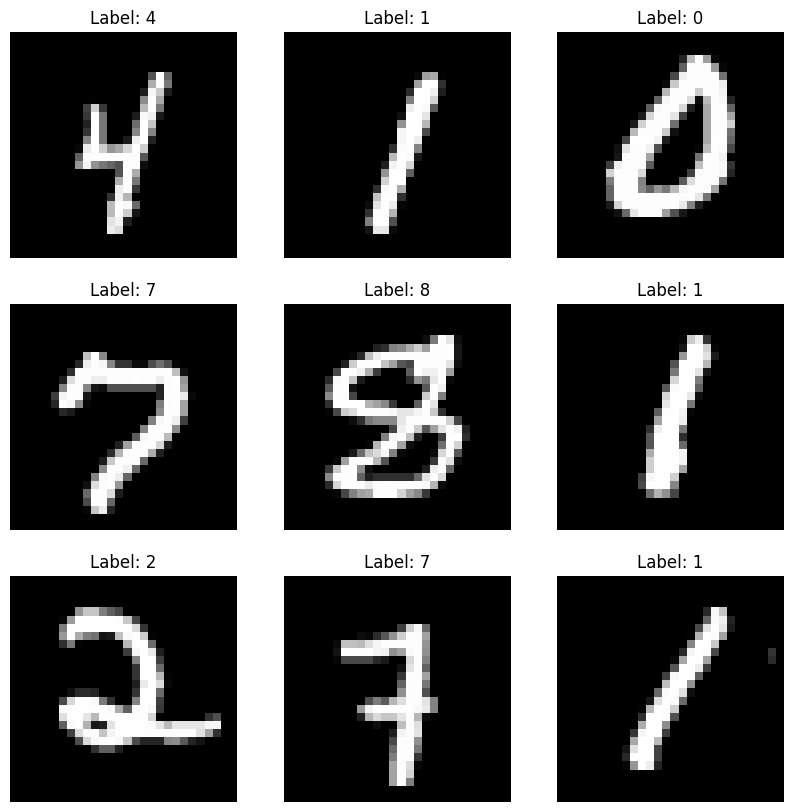

In [353]:
import matplotlib.pyplot as plt

# Take a batch of 9 images from the training dataset
image_batch, label_batch = next(iter(ds_train.take(9).batch(9)))

# Plot the images with their corresponding labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')
    ax.set_title(f"Label: {label_batch[i].numpy()}")
    ax.axis("off")

plt.show()

In [354]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Cargar el dataset MNIST
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


In [355]:
def normalize_img(image, label):
    """Normaliza las imágenes: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


In [356]:
# Función para normalizar y redimensionar las imágenes
def preprocess(image, label):
    image = tf.image.resize(image, (28, 28))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=10)
    return image, label

# Aplicar la función de preprocesamiento
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Preparar los datasets para el entrenamiento
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [357]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Cargar el dataset MNIST
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Función para normalizar y redimensionar las imágenes
def preprocess(image, label):
    image = tf.image.resize(image, (28, 28))
    image = tf.expand_dims(image, axis=-1)  # Añadir la dimensión del canal
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=10)
    return image, label

# Aplicar la función de preprocesamiento
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Verificar la forma de las imágenes
for image, label in ds_train.take(1):
    print(image.shape)  # Debería ser (28, 28, 1)

# Preparar los datasets para el entrenamiento
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


(28, 28, 1, 1)


##Creación del modelo convolucional

In [358]:
# Definir el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(ds_train, epochs=5, validation_data=ds_test)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - accuracy: 0.8343 - loss: 0.5501 - val_accuracy: 0.9792 - val_loss: 0.0681
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.9800 - loss: 0.0636 - val_accuracy: 0.9857 - val_loss: 0.0426
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.9861 - loss: 0.0444 - val_accuracy: 0.9894 - val_loss: 0.0336
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.9902 - loss: 0.0323 - val_accuracy: 0.9897 - val_loss: 0.0332
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9918 - loss: 0.0259 - val_accuracy: 0.9894 - val_loss: 0.0331


In [359]:
print(train_images.shape)  # Debería ser (num_samples, 28, 28, 1)
print(test_images.shape)   # Debería ser (num_samples, 28, 28, 1)


(60000, 28, 28)
(10000, 1, 28, 28)


In [360]:
train_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [361]:
train_features.shape[1:]

(784,)

In [362]:
# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [363]:
print(train_features.shape)
print(train_labels.shape)



(60000, 784)
(60000, 2)


In [364]:
# Assuming 'num_classes' should reflect the true dimensionality of your target data
# Modify the final Dense layer to match the target shape
model.add(Dense(units=train_labels.shape[-1], activation='softmax'))
# This change dynamically adjusts the output layer to match the target data's last dimension.
# For example, if train_labels.shape is (32, 10, 2), the output layer will have 2 units.

# If your target data has multiple labels per sample or a hierarchical structure,
# consider using a different loss function or model architecture to handle it.
# For example, if you have multiple binary classifications per sample,
# you could use 'binary_crossentropy' as the loss function and sigmoid activation
# in the output layer.

In [365]:
import tensorflow as tf

# ... (your existing model definition) ...

# Assuming original train_labels shape is (60000, 10) and you want 2 classes
num_classes = 2

# Reshape or slice train_labels to (60000, num_classes)
# Option 1: Select the first 'num_classes' columns
train_labels = train_labels[:, :num_classes]
# Option 2: If labels are one-hot encoded for 10 classes, convert to 2 classes
# This is just an example, adjust based on your specific label encoding
# if train_labels.shape[-1] == 10:
#     train_labels = tf.keras.utils.to_categorical(
#         tf.argmax(train_labels, axis=-1), num_classes

##Guardar el modelo entrenado

In [376]:
# Guardar el modelo
model.save('mnist_model.keras')

In [377]:
from keras.models import load_model
loaded_model = load_model('mnist_model.keras')

In [368]:
loaded_model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,346 (364.64 KB)

 Trainable params: 93,344 (364.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [385]:
import tensorflow as tf

# Cargar el modelo guardado
loaded_model = tf.keras.models.load_model('mnist_model.keras')

# Agregar una capa densa con 10 salidas y activación softmax
loaded_model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Re-compilar el modelo después de agregar la nueva capa
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Evaluar el modelo cargado
loss, accuracy = loaded_model.evaluate(ds_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Hacer predicciones
predictions = loaded_model.predict(ds_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1113 - loss: 2.3551
Loss: 2.3550078868865967, Accuracy: 0.11349999904632568
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [386]:
loaded_model.evaluate(test_features, test_labels)
predictions = loaded_model.predict(test_features)
#predict_classes = loaded_model.predict_classes(test_features)

predictions

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_60" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 1, 28, 28)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 1, 28, 28), dtype=float32)
  • training=False
  • mask=None

In [392]:
import tensorflow as tf
import numpy as np

# ... (your existing code) ...

# One-hot encode test_labels
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)  # Corrected one-hot encoding

# Reshape test_features to match the expected input shape of the model
# Assuming the original shape was (10000, 1, 28, 28)
# and the model expects (10000, 28, 28, 1)
test_features = test_features.reshape(test_features.shape[0], 28, 28, 1)  # Correct reshaping

# Now evaluate the model
loaded_model.evaluate(test_features, test_labels)
predictions = loaded_model.predict(test_features)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [373]:
y_test = np.argmax(test_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)



AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(predictions[0])
clase = np.argmax(predictions[0])
clase

##Metricas

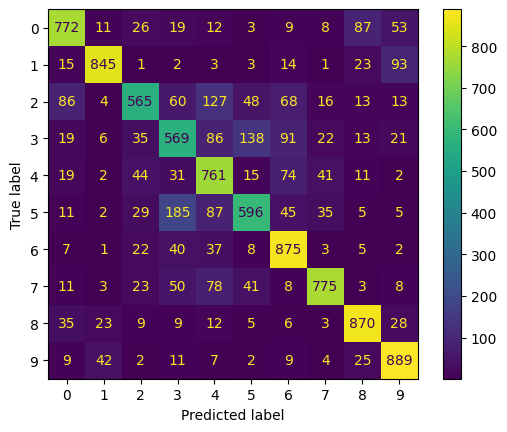

In [372]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Asume que 'y_true' son las etiquetas verdaderas y 'y_pred' son las etiquetas predichas
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Reemplaza con tus etiquetas de clase
disp.plot()
plt.show()

In [374]:
from sklearn.metrics import classification_report

# Asume que 'y_true' son las etiquetas verdaderas y 'y_pred' son las etiquetas predichas
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1000
           1       0.90      0.84      0.87      1000
           2       0.75      0.56      0.64      1000
           3       0.58      0.57      0.58      1000
           4       0.63      0.76      0.69      1000
           5       0.69      0.60      0.64      1000
           6       0.73      0.88      0.80      1000
           7       0.85      0.78      0.81      1000
           8       0.82      0.87      0.85      1000
           9       0.80      0.89      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



##Predicción

In [375]:
import cv2
from google.colab.patches import cv2_imshow

def predecir(path, label):
  #Cargar imagen
  image = cv2.imread(path)

  #Redimensionar 32*32
  imagen_redimensionada = cv2.resize(image, (32, 32))

  #Mostrar imagen
  cv2_imshow(imagen_redimensionada)

  #Predecir la clase
  clase = np.argmax(loaded_model.predict(np.array([imagen_redimensionada])))
  predicted_label = class_names[clase]

  print(f"Etiqueta original: {label}")
  print(f"Etiqueta predicha: {predicted_label}")
